# Titanic dataset exploration

In [48]:
# Imports
import numpy as np
import pandas as pd
from seaborn import heatmap
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [49]:
# Load data and show
data = pd.read_csv("data/train.csv")
submission = pd.read_csv("data/test.csv")

print("Class balance")
print(data["Survived"].value_counts())


Class balance
0    549
1    342
Name: Survived, dtype: int64


### Column description
| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [50]:
# Drop non numeric columns
data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
submission_ids = submission.pop("PassengerId")
submission.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
data


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [51]:
data.describe()


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Notice how minimum age is below 1

In [52]:
# Discard passengers that have age below 1 as they are errors in the data
data = data[data["Age"] > 1]
data.describe()


,Survived,Pclass,Age,SibSp,Parch,Fare
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,0.397143,2.231429,30.275714,0.494286,0.411429,34.715726
std,0.489656,0.841101,14.080663,0.906957,0.847034,53.220615
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,21.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.750000,0.000000,0.000000,15.372900
75%,1.000000,3.000000,39.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


Now minimum age is 1.

### Histogram

Text(0.5, 1.0, 'Survived vs not survived by age')

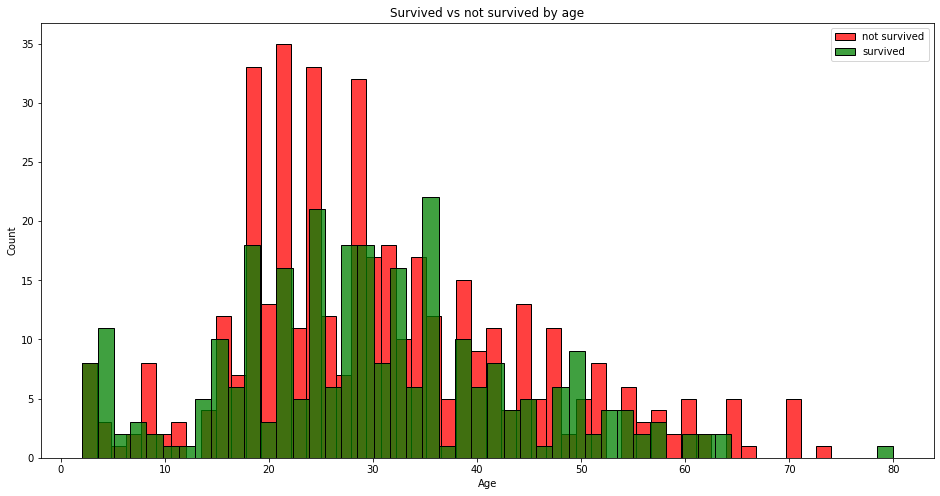

In [53]:
plt.figure(figsize=(16, 8))
sns.histplot(
    data[data["Survived"] == 0].Age.dropna(),
    bins=50,
    label="not survived",
    kde=False,
    color="red",
)
sns.histplot(
    data[data["Survived"] == 1].Age.dropna(),
    bins=50,
    label="survived",
    kde=False,
    color="green",
)
plt.legend()
plt.title("Survived vs not survived by age")


### Categorical values

In [54]:
labels = data.pop("Survived")

# Convert Sex and Embarked columns into categorical columns for data set
dummies = data[["Sex", "Embarked"]]
dummies = pd.get_dummies(dummies, drop_first=True)
data.drop(["Sex", "Embarked"], axis=1, inplace=True)
data = pd.concat([data, dummies], axis=1)

# Convert Sex and Embarked columns into categorical columns for submission set
dummies = submission[["Sex", "Embarked"]]
dummies = pd.get_dummies(dummies, drop_first=True)
submission.drop(["Sex", "Embarked"], axis=1, inplace=True)
submission = pd.concat([submission, dummies], axis=1)
submission


/home/bsn/Documents/virtualenvs/default/lib64/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1
...,...,...,...,...,...,...,...,...
413,3,NaN,0,0,8.0500,1,0,1
414,1,39.0,0,0,108.9000,0,0,0
415,3,38.5,0,0,7.2500,1,0,1
416,3,NaN,0,0,8.0500,1,0,1


In [55]:
# Check empty values on data
data.isna().sum(), submission.isna().sum()


(Pclass        0
 Age           0
 SibSp         0
 Parch         0
 Fare          0
 Sex_male      0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64,
 Pclass         0
 Age           86
 SibSp          0
 Parch          0
 Fare           1
 Sex_male       0
 Embarked_Q     0
 Embarked_S     0
 dtype: int64)

### Use KNN to fill empty values

In [56]:
# MinMax Normalize the data
scaler = MinMaxScaler()
data = pd.DataFrame(
    scaler.fit_transform(data), columns=data.columns
)  # Fit transform on training/testing data
submission = pd.DataFrame(
    scaler.transform(submission), columns=submission.columns
)  # Only transform submission set


# Fill missing values with KNN algorithm
imputer = KNNImputer(n_neighbors=2)
data = pd.DataFrame(
    imputer.fit_transform(data), columns=data.columns
)  # Fit transform on training/testing data
submission = pd.DataFrame(
    imputer.transform(submission), columns=submission.columns
)  # Only transform submission set

data


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1.0,0.256410,0.2,0.000000,0.014151,1.0,0.0,1.0
1,0.0,0.461538,0.2,0.000000,0.139136,0.0,0.0,0.0
2,1.0,0.307692,0.0,0.000000,0.015469,0.0,0.0,1.0
3,0.0,0.423077,0.2,0.000000,0.103644,0.0,0.0,1.0
4,1.0,0.423077,0.0,0.000000,0.015713,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
695,1.0,0.474359,0.0,0.833333,0.056848,0.0,1.0,0.0
696,0.5,0.320513,0.0,0.000000,0.025374,1.0,0.0,1.0
697,0.0,0.217949,0.0,0.000000,0.058556,0.0,0.0,1.0
698,0.0,0.307692,0.0,0.000000,0.058556,1.0,0.0,0.0


In [57]:
# Check empty values on data again
data.isna().sum(), submission.isna().sum()


(Pclass        0
 Age           0
 SibSp         0
 Parch         0
 Fare          0
 Sex_male      0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64,
 Pclass        0
 Age           0
 SibSp         0
 Parch         0
 Fare          0
 Sex_male      0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64)

### Explore correlation matrix

<AxesSubplot:>

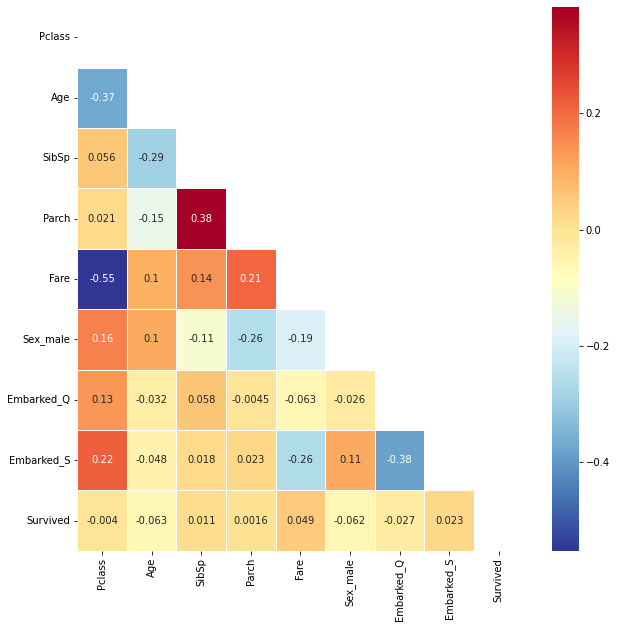

In [58]:
plt.figure(figsize=(10, 10))
heatmap(
    pd.concat(
        [data, labels], axis=1
    ).corr(),  # Temporary concat with labels to check feature correlation
    annot=True,
    linewidth=0.8,
    mask=np.triu(pd.concat([data, labels], axis=1).corr()),
    cmap="RdYlBu_r",
)


### Prediction using SVM

In [59]:
from sklearn.model_selection import train_test_split
from joblib import dump

# Split train and test set keeping negative/positive class ratio
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=0, stratify=labels
)
print(
    f"""Shapes:
    x_train: {x_train.shape}, x_test: {x_test.shape},
    y_train: {y_train.shape}, y_test: {y_test.shape}
    """
)
y_train.value_counts(), y_test.value_counts()

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print(f"class weights: {class_weights}")

Shapes:
    x_train: (560, 8), x_test: (140, 8),
    y_train: (560,), y_test: (140,)
    
class weights: {0: 0.8284023668639053, 1: 1.2612612612612613}


In [60]:
params = {
    "C": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 32, 35],
    "gamma": ["scale", "auto"],
    "kernel": ["linear", "sigmoid", "rbf"],
    "shrinking": [True, False],
    "class_weight": [class_weights]
}

random_search = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring="neg_mean_absolute_error",
    refit="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

random_search.fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=random_search.best_estimator_.predict(x_test)))

dump(random_search, "models/random_search")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        84
           1       0.88      0.66      0.76        56

    accuracy                           0.83       140
   macro avg       0.84      0.80      0.81       140
weighted avg       0.84      0.83      0.82       140



['models/random_search']

### Neural Network

In [61]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets
INFO:tensorflow:Assets written to: models/nn_ckp/assets


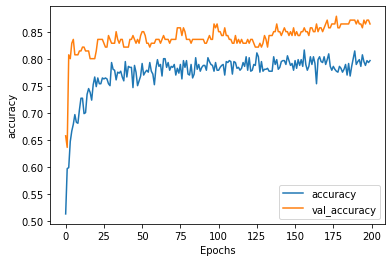

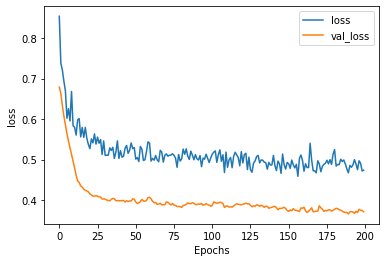

In [62]:
import tensorflow as tf
from tensorflow import keras
import os
import random

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = keras.Sequential(
    [
        keras.layers.Input(shape=len(x_train.iloc[0])),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(units=32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(units=16, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/nn_ckp",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
)

LEARNING_RATE = 1e-3
BATCH_SIZE = 16
EPOCHS = 200

model.compile(
    loss=tf.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["accuracy"],
)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    verbose=0,
    class_weight=class_weights,
    callbacks=[checkpoint],
)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [63]:
best_model = keras.models.load_model("models/nn_ckp")
predictions = [0 if x < 0.5 else 1 for x in best_model.predict(x_test)]
print(classification_report(y_true=y_test, y_pred=predictions))


              precision    recall  f1-score   support

           0       0.89      0.90      0.90        84
           1       0.85      0.84      0.85        56

    accuracy                           0.88       140
   macro avg       0.87      0.87      0.87       140
weighted avg       0.88      0.88      0.88       140



In [64]:
results = [0 if x < 0.5 else 1 for x in best_model.predict(submission)]
file = pd.DataFrame({"predicted_survived": results}, index=submission_ids)
file.to_csv("submission_file.csv")
